In [1]:
%load_ext autoreload
%autoreload 2

,f0,f1,f2,f3,choice
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.498831,0.498391,0.496947,0.496930,-3.654070
std,0.281851,0.285530,0.291431,0.290942,0.407711
min,0.000036,0.000184,0.000332,0.000037,-4.732636
25%,0.253412,0.245748,0.245258,0.235843,-3.963428
50%,0.500025,0.500173,0.500075,0.500059,-3.623297
75%,0.743091,0.745965,0.747204,0.750282,-3.383307
max,0.998907,0.999978,0.999739,0.999854,-2.541356


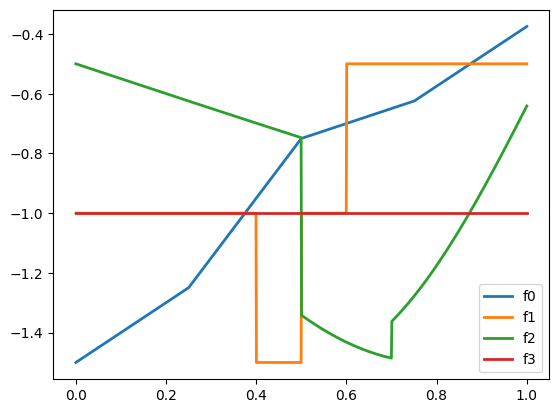

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from rumboost.metrics import cross_entropy
np.random.seed(0)

def compute_levels(sp, betas):
    levels = np.zeros(len(sp))
    for i in range(len(sp) - 1):
        levels[i + 1] = levels[i] + (sp[i + 1] - sp[i]) * betas[i]
    return levels


def create_pw_linear_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    levels = compute_levels(sp, betas) + intercept
    f_x = levels[indices] + betas[indices] * (x - sp[indices])

    return f_x


def apply_linear_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_linear_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_pw_constant_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = betas[indices] + intercept

    return f_x

def apply_constant_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_constant_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data

def create_sinusoidal_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = np.sin(betas[indices] * x) + intercept
    return f_x

def apply_sinusoidal_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_sinusoidal_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_dataset(x_arr, feature_names):
    return pd.DataFrame({feature_names[i]: x_arr[:, i] for i in range(x_arr.shape[1])})


def generate_x(n, k, props_low=0.5, cut=0.5, deterministic=False):
    n_low = int(props_low * n)
    n_high = n - n_low
    if deterministic:
        x_low = np.linspace([0]*n_utility, [cut]*n_utility, n_low)
        x_high = np.linspace([cut]*n_utility, [1]*n_utility, n_high)
    else:
        x_low = np.random.uniform(0, cut, (n_low, k))
        x_high = np.random.uniform(cut, 1, (n_high, k))

    return np.concatenate([x_low, x_high], axis=0)


def add_choice(row, u_idx, regression=False):
    u = np.array([np.sum(row[u_idx[i][0] : u_idx[i][1]]) for i in range(len(u_idx))])
    if regression:
        return u[0]
    else:
        return np.random.choice(u.shape[0], size=1, p=softmax(u))[0]

n_utility = 1 
regression = n_utility == 1
f_per_utility = 4
x_arr = generate_x(2000, n_utility * f_per_utility, 0.5, 0.5)
# x_arr[:, 1] = x_arr[:, 0]
# x_arr[:, 2] = x_arr[:, 0]
x_arr_test = generate_x(1000, n_utility * f_per_utility, 0.5, 0.5)
# x_arr_test[:, 1] = x_arr_test[:, 0]
# x_arr_test[:, 2] = x_arr_test[:, 0]
sp = np.array(
    [
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
        [0, 0.3, 0.5, 0.7, 1],
        [0, 0.2, 0.4, 0.5, 1],
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
        [0, 0.34, 0.5, 0.55, 1],
        [0, 0.2, 0.4, 0.8, 1],
        [0, 0.1, 0.55, 0.6, 1],
        [0, 0.3, 0.5, 0.7, 1],
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
        [0, 0.3, 0.5, 0.7, 1],
        [0, 0.2, 0.4, 0.5, 1],
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
    ]
)
betas = np.array(
    [
        [1, 2, 0.5, 1],
        [0.5, 0, 0.5, 1],
        [-0.5, -0.5, -2, -3],
        [0, 0, 0, 0],
        [3, -2, 0.5, -1],
        [0.5, 0, 0.5, 1],
        [-0.5, -0.5, -2, -3],
        [0, 1, 1, 0],
        [1, -2, 0.5, -1],
        [-0.5, 0, 0.5, 1],
        [-0.5, -0.5, -2, -3],
        [0, 0, 5, 0],
        [1, 1, 0.9, -1],
        [0.5, -1, 0.5, 1],
        [-0.5, -0.5, 2, -3],
        [0, -1, 0, 0],
    ]
)
intercept = [-1.5, -1.5, -0.5, -1, 0, -2, 1, -2, 1, -1, -0.5, 0.5, -2, 0, 0, 0.5]

ind = [i for i in range(4 * n_utility) if i % 4 < f_per_utility]
sp = [sp[i] for i in ind]
betas = [betas[i] for i in ind]
intercept = [intercept[i] for i in ind]

feature_names = [f"f{i}" for i in range(f_per_utility*n_utility)]

u_idx = [(i * f_per_utility, (i+1) * f_per_utility) for i in range(n_utility)]

x_plot = np.linspace(1e-4, 1, 1000).reshape(-1, 1)
for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
    if i % 4 == 0:
        y_plot = apply_linear_feature(
            x_plot, sp_i.reshape(1, -1), beta_i.reshape(1, -1), feature_names, [inter_i]
        ).values
    elif i % 4 == 1:
        y_plot = apply_constant_feature(
            x_plot, sp_i.reshape(1, -1), beta_i.reshape(1, -1), feature_names, [inter_i]
        ).values
    elif i % 4 == 2:
        y_plot = apply_sinusoidal_feature(
            x_plot, sp_i.reshape(1, -1), beta_i.reshape(1, -1), feature_names, [inter_i]
        ).values
    else:
        y_plot = apply_linear_feature(
            x_plot, sp_i.reshape(1, -1), beta_i.reshape(1, -1), feature_names, [inter_i]
        ).values
    plt.plot(x_plot, y_plot, label=feature_names[i], linewidth=2)

plt.legend()

dataset = create_dataset(x_arr, feature_names)
dataset_transf = pd.DataFrame()
for i in range(x_arr.shape[1]):
    if i % 4 == 0:
        dataset_transf.loc[:, feature_names[i]] = apply_linear_feature(
            x_arr[:,i].reshape(-1,1), sp[i].reshape(1, -1), betas[i].reshape(1, -1), feature_names, [intercept[i]]
        )
    elif i % 4 == 1:
        dataset_transf.loc[:, feature_names[i]] = apply_constant_feature(
            x_arr[:,i].reshape(-1,1), sp[i].reshape(1, -1), betas[i].reshape(1, -1), feature_names, [intercept[i]]
        )
    elif i % 4 == 2:
        dataset_transf.loc[:, feature_names[i]] = apply_sinusoidal_feature(
            x_arr[:,i].reshape(-1,1), sp[i].reshape(1, -1), betas[i].reshape(1, -1), feature_names, [intercept[i]]
        )
    else:
        dataset_transf.loc[:, feature_names[i]] = apply_linear_feature(
            x_arr[:,i].reshape(-1,1), sp[i].reshape(1, -1), betas[i].reshape(1, -1), feature_names, [intercept[i]]
        )

dataset["choice"] = dataset_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)
dataset_test = create_dataset(x_arr_test, feature_names)
dataset_test_transf = pd.DataFrame()
for i in range(len(sp)):
    if i % 4 == 0:
        dataset_test_transf.loc[:, feature_names[i]] = apply_linear_feature(
            x_arr_test[:,i].reshape(-1,1), sp[i].reshape(1, -1), betas[i].reshape(1, -1), feature_names, [intercept[i]]
        )
    elif i % 4 == 1:
        dataset_test_transf.loc[:, feature_names[i]] = apply_constant_feature(
            x_arr_test[:,i].reshape(-1,1), sp[i].reshape(1, -1), betas[i].reshape(1, -1), feature_names, [intercept[i]]
        )
    elif i % 4 == 2:
        dataset_test_transf.loc[:, feature_names[i]] = apply_sinusoidal_feature(
            x_arr_test[:,i].reshape(-1,1), sp[i].reshape(1, -1), betas[i].reshape(1, -1), feature_names, [intercept[i]]
        )
    else:
        dataset_test_transf.loc[:, feature_names[i]] = apply_linear_feature(
            x_arr_test[:,i].reshape(-1,1), sp[i].reshape(1, -1), betas[i].reshape(1, -1), feature_names, [intercept[i]]
        )
dataset_test["choice"] = dataset_test_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)

dataset.describe()

## Gradient boosting with linear trees

In [11]:
import copy
def compute_preds(X):
    preds = softmax(X, axis=1)
    return preds

def compute_grads_and_hess(preds, labels, num_classes=3):
    if num_classes > 1:
        grads = preds - labels
        factor = num_classes / (num_classes - 1)
        hess = factor * preds * (1 - preds)
        hess = np.maximum(hess, 1e-6)
    else:
        grads = (preds - labels)
        hess = np.ones_like(preds)
    return grads, hess


def truncate(grads, hess, x, grads_x, hess_x, split, left=True):

    best_gain = 0
    best_split = None


    for second_split in np.unique(x):
        if second_split == split:
            continue
        if second_split < 0.01 or second_split > 0.99:
            continue
        if np.abs(split-second_split) < 0.01:
            continue
        left_mask = x <= second_split
        right_mask = x > second_split
        grads_left = grads[left_mask]
        hess_left = hess[left_mask]
        grads_right = grads[right_mask]
        hess_right = hess[right_mask]
        grads_x_left = grads_x[left_mask]
        hess_x_left = hess_x[left_mask]
        grads_x_right = grads_x[right_mask]
        hess_x_right = hess_x[right_mask]

        if left:
            beta = - grads_x_right.sum() / hess_x_right.sum()
            new_gain = np.sum(grads_x_right) **2 / hess_x_right.sum() - np.sum(grads_x)**2/hess_x.sum() - np.sum(grads_left) * beta * (second_split-split) - 0.5 * np.sum(hess_left)* (beta ** 2) * (second_split - split) ** 2
        else:
            beta = - grads_x_left.sum() / hess_x_left.sum()
            new_gain = np.sum(grads_x_left)**2 / hess_x_left.sum() - np.sum(grads_x)**2/hess_x.sum() - np.sum(grads_right) * beta * (second_split-split) - 0.5 * np.sum(hess_right) * (beta ** 2) * (second_split - split) ** 2



        if new_gain > best_gain:
            best_gain = new_gain
            best_split = second_split

    if best_gain == 0:
        return None, None
    else:
        return best_split, best_gain
    



def compute_split_gain(grads, hess, split, feature, one_sided=False, grads_x=None, hess_x=None, from_split_point=False):
    left_mask = feature <= split
    right_mask = feature > split
    left_grads = grads[left_mask]
    right_grads = grads[right_mask]
    left_hess = hess[left_mask]
    right_hess = hess[right_mask]
    if grads_x is not None and hess_x is not None:
        left_grads_x = grads_x[left_mask]
        right_grads_x = grads_x[right_mask]
        left_hess_x = hess_x[left_mask]
        right_hess_x = hess_x[right_mask]
        
        no_split_gain = np.sum(grads_x) ** 2 / np.sum(hess_x)
        left_gain = np.sum(left_grads_x) ** 2 / np.sum(left_hess_x)
        right_gain = np.sum(right_grads_x) ** 2 / np.sum(right_hess_x)
        if split < 0.01 or split > 0.99:
            left_gain_x = 0
            right_gain_x = 0
        else:
            if not from_split_point:
                beta_l = - np.sum(left_grads_x) / np.sum(left_hess_x)
                right_gain_x = np.sum(right_grads * beta_l * split) + 0.5 * np.sum(right_hess * beta_l ** 2 * split ** 2)
                left_gain = left_gain + right_gain_x
                beta_r = - np.sum(right_grads_x) / np.sum(right_hess_x)
                left_gain_x = np.sum(left_grads * beta_r * split) + 0.5 * np.sum(left_hess * beta_r ** 2 * split ** 2)
                right_gain = right_gain + left_gain_x
    else:
        no_split_gain = np.sum(grads) ** 2 / np.sum(hess)
        left_gain = np.sum(left_grads) ** 2 / np.sum(left_hess)
        right_gain = np.sum(right_grads) ** 2 / np.sum(right_hess)

    bigger_gain_left = left_gain > right_gain

    if one_sided:
        if bigger_gain_left:
            if from_split_point:
                right_gain = left_gain_x
            else:
                right_gain = 0
        else:
            if from_split_point:
                left_gain = right_gain_x
            else:
                left_gain = 0
    gain = left_gain + right_gain - no_split_gain
    return gain, bigger_gain_left

def find_best_split(X, grads, hess, linear_trees=False, from_split_point=False):
    best_gain = -np.inf
    best_split = None
    best_feature = None
    best_bigger_gain_left = None
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    for feature in range(X.shape[1]):
        unique_values = np.unique(X[:, feature])
        for split in unique_values:
            if linear_trees and from_split_point:
                grads_ = grads * (X[:, feature] - split)
                hess_ = hess * (X[:, feature] - split)**2
                one_sided = False
            elif linear_trees:
                grads_ = grads * (X[:, feature])
                hess_ = hess * (X[:, feature])**2
                one_sided = True
            else:
                grads_ = None
                hess_ = None 
                one_sided = False
            gain, bigger_gain_left = compute_split_gain(grads, hess, split, X[:, feature], one_sided=one_sided, grads_x=grads_, hess_x=hess_, from_split_point=from_split_point)

            if gain > best_gain:
                best_gain = copy.deepcopy(gain)
                best_split = copy.deepcopy(split)
                best_feature = copy.deepcopy(feature)
                best_bigger_gain_left = copy.deepcopy(bigger_gain_left)
        

    return best_feature, best_split, best_gain, best_bigger_gain_left

def compute_leaf_value(grads, hess, feature, split, linear_trees=False, from_split_point=False, second_split_left=None, second_split_right=None):
    no_split_value = - np.sum(grads) / np.sum(hess)
    left_mask = feature <= split
    right_mask = feature > split

    if linear_trees and from_split_point:
        grads = grads * (feature - split)
        hess = hess * (feature - split)**2
        if second_split_left:
            grads = grads * ((feature - split) >= (second_split_left - split))
            hess = hess * ((feature - split) >= (second_split_left - split))
        if second_split_right:
            grads = grads * ((feature - split) <= (second_split_right - split))
            hess = hess * ((feature-split) <= (second_split_right - split))
    elif linear_trees:
        grads = grads * (feature)
        hess = hess * (feature)**2

    
    left_grads = grads[left_mask]
    right_grads = grads[right_mask]
    left_hess = hess[left_mask]
    right_hess = hess[right_mask]

    left_value = - np.sum(left_grads) / np.sum(left_hess)
    right_value = - np.sum(right_grads) / np.sum(right_hess)

    return left_value, right_value, no_split_value

def boost(X, y, preds, num_classes=3, linear_trees=False, from_split_point=False):
    grads, hess = compute_grads_and_hess(preds, y, num_classes=num_classes)
    feature, split, gain, bigger_left = find_best_split(X, grads, hess, linear_trees=linear_trees, from_split_point=from_split_point)
    if linear_trees and from_split_point:
        left_grads = grads[X[:, feature] <= split]
        left_hess = hess[X[:, feature] <= split]
        left_grads_x = left_grads * (X[X[:, feature] <= split, feature] - split)
        left_hess_x = left_hess * (X[X[:, feature] <= split, feature] - split)**2
        second_split_left, gain_left = truncate(left_grads, left_hess, x=X[X[:, feature] <= split,feature], grads_x=left_grads_x, hess_x=left_hess_x, split=split, left=True)
       
        right_grads = grads[X[:, feature] > split]
        right_hess = hess[X[:, feature] > split]
        right_grads_x = right_grads * (X[X[:, feature] > split, feature] - split)
        right_hess_x = right_hess * (X[X[:, feature] > split, feature] - split)**2
        second_split_right, gain_right = truncate(right_grads, right_hess, x=X[X[:, feature] > split,feature], grads_x=right_grads_x, hess_x=right_hess_x, split=split, left=False)

        if second_split_left:
            gain += gain_left
        
        if second_split_right:
            gain += gain_right
    second_split_left = None
    second_split_right = None

    left_value, right_value, no_split_value = compute_leaf_value(grads, hess, X[:, feature].reshape(-1), split, linear_trees=linear_trees, from_split_point=from_split_point, second_split_left=second_split_left, second_split_right = second_split_right)

    return feature, split, left_value, right_value, gain, no_split_value, bigger_left, second_split_left, second_split_right

In [12]:
class Tree:
    def __init__(self, linear_trees=False, from_split_point=False):
        self.linear_trees = linear_trees
        self.from_split_point = from_split_point
        self.tree = None

    def fit(self, X, y, preds, num_classes=3):
        self.tree = self._build_tree(X, y, preds, num_classes=num_classes)

    def _build_tree(self, X, y, preds, num_classes=3):

        feature, split, left_value, right_value, gain, no_split_value, bigger_left, second_split_left, second_split_right = boost(X, y, preds, num_classes=num_classes, linear_trees=self.linear_trees, from_split_point=self.from_split_point)
        if gain <= 0:
            return None
        
        if self.linear_trees and not self.from_split_point:
            if bigger_left:
                right_value = 0
            else:
                left_value = 0

        return {
            "feature": feature,
            "split": split,
            "left_value": left_value if (self.linear_trees and not self.from_split_point) else left_value,
            # "left_value": left_value,
            "right_value": right_value,
            "gain": gain,
            "left_constant": split * right_value  if not self.from_split_point else None,
            # "left_constant": split * right_value + no_split_value if not self.from_split_point else None,
            "right_constant": split * left_value if not self.from_split_point else None,
            # "right_constant": split * -left_value + no_split_value if not self.from_split_point else None,
            "second_split_left": second_split_left,
            "second_split_right": second_split_right,
            "full_intercept": no_split_value,
        }

In [13]:
class Ensemble:
    def __init__(self, linear_trees=False, from_split_point=False):
        self.linear_trees = linear_trees
        self.from_split_point = from_split_point
        self.trees = []

    def fit(self, X, y, preds, num_classes=3):
        tree = Tree(linear_trees=self.linear_trees, from_split_point=self.from_split_point)
        tree.fit(X, y, preds, num_classes=num_classes)
        self.trees.append(tree)

    def predict(self, X):
        preds = np.zeros((X.shape[0]))
        for tree in self.trees:
            if tree.tree is not None:
                split = tree.tree["split"]
                feature = tree.tree["feature"]
                left_value = tree.tree["left_value"]
                right_value = tree.tree["right_value"]
                left_constant = tree.tree["left_constant"]
                right_constant = tree.tree["right_constant"]
                second_split_left = tree.tree["second_split_left"]
                second_split_right = tree.tree["second_split_right"]
                full_intercept = tree.tree["full_intercept"]

                x_f = X[:, feature]
                if second_split_left is None:
                    second_split_left = x_f.min()
                if second_split_right is None:
                    second_split_right = x_f.max()

                if self.linear_trees and self.from_split_point:
                    # preds[x_f <= split] += left_value * (x_f[x_f <= split] - split)
                    # preds[x_f > split] += right_value * (x_f[x_f > split] - split) 
                    preds[x_f <= split] += left_value * np.maximum(x_f[x_f <= split] - split, second_split_left - split)
                    preds[x_f > split] += right_value * np.minimum(x_f[x_f > split] - split, second_split_right - split)
                elif self.linear_trees:
                    # preds[x_f <= split] += left_value * x_f[x_f <= split] - left_constant + full_intercept
                    # preds[x_f <= split] += left_value * x_f[x_f <= split] + right_constant + full_intercept
                    preds[x_f <= split] += left_value * x_f[x_f <= split] + right_constant 
                    # preds[x_f <= split] += left_value * x_f[x_f <= split] 
                    # preds[x_f > split] += right_value * x_f[x_f > split] - right_constant + full_intercept
                    # preds[x_f > split] += right_value * x_f[x_f > split] + left_constant + full_intercept
                    preds[x_f > split] += right_value * x_f[x_f > split] + left_constant 
                    # preds = preds - left_constant - right_constant + full_intercept
                    # preds = preds - left_constant - right_constant - full_intercept
                    # preds[x_f > split] += right_value * x_f[x_f > split] 
                else:
                    preds[x_f <= split] += left_value
                    preds[x_f > split] += right_value

        return preds

In [14]:
class BoostingModel:
    def __init__(self, n_estimators=10, learning_rate=0.1, num_classes=3, linear_trees=False, from_split_point=False, feature_indices=None):
        self.linear_trees = linear_trees
        self.from_split_point = from_split_point
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.ensemble = [Ensemble(linear_trees=self.linear_trees, from_split_point=self.from_split_point) for _ in range(num_classes)]
        self.feature_indices = feature_indices
        if self.feature_indices is None:
            self.feature_indices = [(i, i+1) for i in range(num_classes)]

    def fit(self, X, y, X_test=None, y_test=None):
        self.initial_preds = np.zeros((1, self.num_classes))
        if self.num_classes > 1:
            for j in range(self.num_classes):
                self.initial_preds[:, j] = np.log(np.mean(y==j))
            raw_preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()
            preds = softmax(raw_preds, axis=1)
            print("Initial train cel:", cross_entropy(preds, y))

            if X_test is not None and y_test is not None:
                test_preds = np.zeros((X_test.shape[0], self.num_classes)) + self.initial_preds.copy()
                test_preds = softmax(test_preds, axis=1)
                print("Initial test cel:", cross_entropy(test_preds, y_test))
        else:
            self.initial_preds[:, 0] = np.mean(y)
            raw_preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()
            preds = raw_preds
            print("Initial train mse:", np.mean((preds - y.reshape(-1, 1))**2))

            if X_test is not None and y_test is not None:
                test_preds = np.zeros((X_test.shape[0], self.num_classes)) + self.initial_preds.copy()
                print("Initial test mse:", np.mean((test_preds - y_test.reshape(-1, 1))**2))
            
        for i in range(self.n_estimators):
            raw_preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()
            for j in range(self.num_classes):
                ensemble = self.ensemble[j]
                target = y == j if self.num_classes > 1 else y
                ensemble.fit(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]], target, preds[:, j], num_classes=self.num_classes)
                raw_preds[:, j] += self.learning_rate * ensemble.predict(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]])
            if self.num_classes > 1:
                preds = softmax(raw_preds, axis=1)
                print("Train cel:", cross_entropy(preds, y))
            else:
                preds = raw_preds
                print("Train mse:", np.mean((preds - y.reshape(-1, 1))**2))

            if X_test is not None and y_test is not None:
                raw_test_preds = np.zeros((X_test.shape[0], self.num_classes)) + self.initial_preds.copy()
                for j in range(self.num_classes):
                    ensemble = self.ensemble[j]
                    raw_test_preds[:, j] += self.learning_rate * ensemble.predict(X_test[:, self.feature_indices[j][0]:self.feature_indices[j][1]])
                if self.num_classes > 1:
                    test_preds = softmax(raw_test_preds, axis=1)
                    print("Test cel:", cross_entropy(test_preds, y_test))
                else:
                    test_preds = raw_test_preds
                    print("Test mse:", np.mean((test_preds - y_test.reshape(-1, 1))**2))

    def predict(self, X, utilities=False):
        preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()

        for j in range(self.num_classes):
            ensemble = self.ensemble[j]
            preds[:, j] += self.learning_rate * ensemble.predict(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]])

        return softmax(preds, axis=1) if not utilities else preds

In [15]:
features = [f for f in dataset.columns if f not in ["choice"]]
X, y = dataset[features].values, dataset["choice"].values
X_test, y_test = dataset_test[features].values, dataset_test["choice"].values
feature_indices = [(i * f_per_utility, (i + 1) * f_per_utility) for i in range(n_utility)]

model = BoostingModel(n_estimators=100, learning_rate=0.2, num_classes=n_utility, linear_trees=True, from_split_point=True, feature_indices=feature_indices)

model.fit(X, y, X_test=X_test, y_test=y_test)
for ensemble in model.ensemble:
    for tree in ensemble.trees:
        feature, split, left_value, right_value, gain, left_constant, right_constant, left_intercept, right_intercept, full_intercept = tree.tree.values()
        print(f"Feature: {feature}, Split: {split}, Gain: {gain}, Left value: {left_value}, Right value: {right_value}, Full intercept: {full_intercept}, Left intercept: {left_intercept}, Right intercept: {right_intercept}")

if n_utility > 1:
    preds = model.predict(X_test)
    cel = cross_entropy(preds, y_test)
    print(f"Cross-entropy loss: {cel}")
else:
    preds = model.predict(X_test, utilities=True)
    mse = np.mean((preds - y_test.reshape(-1, 1))**2)
    print(f"Mean squared error: {mse}")

Initial train mse: 0.16614544829406014
Initial test mse: 0.17112861584366318


C:\Users\ucesnjs\AppData\Local\Temp\ipykernel_23828\3360502943.py:77: RuntimeWarning: invalid value encountered in scalar divide
  left_gain = np.sum(left_grads_x) ** 2 / np.sum(left_hess_x)
C:\Users\ucesnjs\AppData\Local\Temp\ipykernel_23828\3360502943.py:78: RuntimeWarning: invalid value encountered in scalar divide
  right_gain = np.sum(right_grads_x) ** 2 / np.sum(right_hess_x)


Train mse: 0.138436018517841
Test mse: 0.14289392346922225
Train mse: 0.12036492781873531
Test mse: 0.12459281615898316
Train mse: 0.10139367906689516
Test mse: 0.10419775815645904
Train mse: 0.09210852273272703
Test mse: 0.094869941022141
Train mse: 0.0812023620289181
Test mse: 0.08304956131309955
Train mse: 0.0739370065408352
Test mse: 0.07511383182055133
Train mse: 0.07034463740954387
Test mse: 0.07156494406330559
Train mse: 0.06678255418726557
Test mse: 0.06811505610716888
Train mse: 0.06321588100806246
Test mse: 0.06412792081895145
Train mse: 0.06141191634111637
Test mse: 0.062406707143742544
Train mse: 0.05920756326723919
Test mse: 0.05989473838974577
Train mse: 0.05823398130878862
Test mse: 0.058983525589284276
Train mse: 0.0567330299236882
Test mse: 0.05724391957582465
Train mse: 0.05607474848141949
Test mse: 0.056632924175971155
Train mse: 0.054950547142439646
Test mse: 0.055317301674769115
Train mse: 0.05441655936259129
Test mse: 0.054822558563321036
Train mse: 0.053532834769

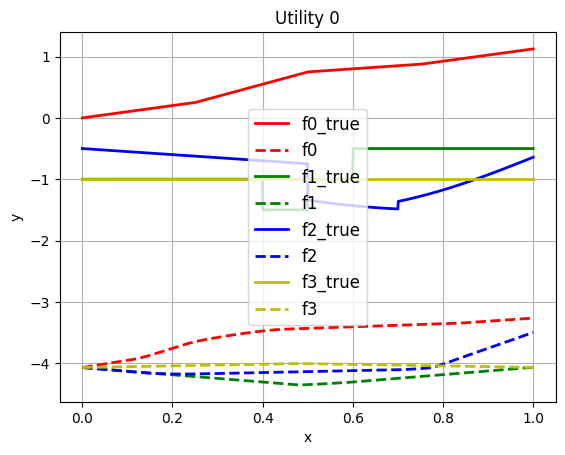

In [16]:
x_plot = np.linspace(1e-4, 1, 1000)

y_plot = []

for i in range(len(feature_names)):
    plot_dataset = pd.DataFrame({feature_names[i]: np.zeros_like(x_plot) for i in range(f_per_utility*n_utility)})
    plot_dataset[feature_names[i]] = x_plot

    if n_utility == 2:
        y_plot.append(model.predict(plot_dataset.values, utilities=True))
    else:
        y_plot.append(model.predict(plot_dataset.values, utilities=True)[:, i // f_per_utility])

colours = ["r", "g", "b", "y", "k", "magenta", "cyan", "orange", "purple", "brown", "pink", "grey", "olive", "lime", "teal", "coral"]


if n_utility == 2:
    
    y_plot_true = []
    for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
        if i % f_per_utility == 0:
            plt.figure()
        y_plot_true.append(apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [0]).values)
    
    y_plot_ttrue = [y_1 - y_0 for y_0, y_1 in zip(y_plot_true[0], y_plot_true[1])]
    y_plot_ttrue = np.array(y_plot_ttrue).reshape(-1)

    plt.plot(x_plot, y_plot_ttrue, label=f"{feature_names[0]}_true", color=colours[0], linewidth=2)
        # ascc = ascs[i//f_per_utility].cpu().numpy() if LPMC_model_fully_trained.device is not None else ascs[i//f_per_utility]
        # plt.plot(x_plot, y_plot[i]+ascc, label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)
    plt.plot(x_plot, y_plot[0], label=feature_names[0], color=colours[0], linestyle="--", linewidth=2)

    plt.title(f"Utility 0")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.legend(fontsize=12)
    plt.show()
else:
    for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
        if i % f_per_utility == 0:
            plt.figure()
        if i % f_per_utility == 0:
            y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [0]).values
        elif i % f_per_utility == 1:
            y_plot_true = apply_constant_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        elif i % f_per_utility == 2:
            y_plot_true = apply_sinusoidal_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        elif i % f_per_utility == 3:
            y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        # y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        plt.plot(x_plot, y_plot_true, label=f"{feature_names[i]}_true", color=colours[i], linewidth=2)
        # ascc = ascs[i//f_per_utility].cpu().numpy() if LPMC_model_fully_trained.device is not None else ascs[i//f_per_utility]
        # plt.plot(x_plot, y_plot[i]+ascc, label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)
        plt.plot(x_plot, y_plot[i], label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)



        if i % f_per_utility == f_per_utility - 1:
            plt.title(f"Utility {i//f_per_utility}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.grid()
            plt.legend(fontsize=12)
            plt.show()

    # for i in range(len(feature_names)):
    #     plt.figure()
    #     plt.hist(dataset[feature_names[i]], bins=150, alpha=0.5, label=feature_names[i])

In [65]:
lr = 0.2
md = 1
verbose = 2
mono = False 
# monotonicity_0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1] if mono else [0]*17
monotonicity_0 = [1, 1, -1, 0] if mono else [0] * 17
# monotonicity_0 = [1] if mono else [0] * 17
l1 = 0
l2 = 0
min_data_in_leaf = 20
min_sum_hessian_in_leaf = 1e-3
min_data_in_bin = 1
mb =255 
bf=1
bfr=0
variables_0 = feature_names[:f_per_utility]
dico1 = []
for i, v in enumerate(variables_0):
    dico1.append({
        "utility": [0],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "objective": "regression",
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_0[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
            # "num_classes": 1,
            "bagging_fraction": bf,
            "bagging_freq": bfr,
        },
        "shared": False,
        "init_leaf_val": monotonicity_0[i]
    })

# monotonicity_1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1] if mono else [0]*17
monotonicity_1 = [0, 1, -1, 1] if mono else [0]*17
# monotonicity_1 = [1] if mono else [0]*17
variables_1 = feature_names[f_per_utility:2*f_per_utility]
dico2 = []
for i, v in enumerate(variables_1):
    dico2.append({
        "utility": [1],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_1[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
        "init_leaf_val": monotonicity_1[i]
    })
    
monotonicity_3 = [0 ,0, -1, 1] if mono else [0]*23
# monotonicity_3 = [1] if mono else [0]*23
# monotonicity_3 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1] if mono else [0]*23
variables_3 = feature_names[2*f_per_utility:3*f_per_utility]
dico3 = []
for i, v in enumerate(variables_3):

    dico3.append({
        "utility": [2],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_3[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
        "init_leaf_val": monotonicity_3[i]
    })

monotonicity_4 = [0, 0, 0, -1] if mono else [0]*20
# monotonicity_4 = [1] if mono else [0]*20
variables_4 = feature_names[3*f_per_utility:]
dico4 = []
for i, v in enumerate(variables_4):
    dico4.append({
        "utility": [3],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_4[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
        "init_leaf_val": monotonicity_4[i]
    })

# rum_structure = dico1 + dico2 + dico3 #+ dico4
if n_utility == 4:
    rum_structure = dico1 + dico2 + dico3 + dico4
elif n_utility == 3:
    rum_structure = dico1 + dico2 + dico3
else:
    rum_structure = dico1
boost_from_param_space2 = [False] * len(rum_structure)
boost_from_param_space = [True] * len(rum_structure)
# rum_structure2 = copy.deepcopy(rum_structure)
rum_structure = rum_structure #+ rum_structure2


In [66]:
# parameters
general_params = {
    "n_jobs": -1,
    "num_classes": n_utility,  # important
    "verbosity": 2,  # specific RUMBoost parameter
    "num_iterations": 300,
    # "early_stopping_round": 10,
    # "max_booster_to_update": 23 * 4,
    # "max_booster_to_update": 17 * 4,
    # "max_booster_to_update": 8,
    "max_booster_to_update": n_utility * f_per_utility,
    # "max_booster_to_update": 1,
    # "max_booster_to_update": n_utility,
    # "boost_from_parameter_space": boost_from_param_space + boost_from_param_space2,
    "boost_from_parameter_space": boost_from_param_space, #+ boost_from_param_space2, #+ [False]*len(rum_structure2),
    "verbose_interval": 1,
    "optim_interval": 1,
    "objective": "regression",
}

In [67]:
torch_tensors = {"device":"cuda"}
# torch_tensors = None

In [68]:
model_specification = {
    "general_params": general_params,
    "rum_structure": rum_structure,
}

In [69]:
dataset.choice.mean()

np.float64(-3.6540699617010524)

In [70]:
import pandas as pd
import lightgbm
from rumboost.rumboost import rum_train
# features and label column names
features = [f for f in dataset.columns if f != "choice"]
label = "choice"

# create lightgbm dataset
lgb_train_set = lightgbm.Dataset(
    dataset, label=dataset[label], free_raw_data=False
)
lgb_test_set = lightgbm.Dataset(
    dataset_test, label=dataset_test[label], free_raw_data=False
)

In [71]:
lgb_train_set.get_label().mean()

np.float64(-3.6540699617010524)

In [79]:
LPMC_model_fully_trained = rum_train(lgb_train_set, model_specification, valid_sets=[lgb_test_set], torch_tensors=torch_tensors)

Using torch tensors on cuda
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval


c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\pwl-experiment\src\rumboost\rumboost.py:2772: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]------NCE value on train set : 0.0958
---------NCE value on test set 1: 0.4724
[2]------NCE value on train set : 0.0728
---------NCE value on test set 1: 0.4342
[3]------NCE value on train set : 0.0643
---------NCE value on test set 1: 0.4085
[4]------NCE value on train set : 0.0598
---------NCE value on test set 1: 0.4019
[5]------NCE value on train set : 0.0564
---------NCE value on test set 1: 0.3969
[6]------NCE value on train set : 0.0537
---------NCE value on test set 1: 0.3927
[7]------NCE value on train set : 0.0513
---------NCE value on test set 1: 0.3918
[8]------NCE value on train set : 0.0492
---------NCE value on test set 1: 0.3872
[9]------NCE value on train set : 0.0474
---------NCE value on test set 1: 0.3864
[10]-----NCE value on train set : 0.0459
---------NCE value on test set 1: 0.3825
[11]-----NCE value on train set : 0.0445
---------NCE value on test set 1: 0.3820
[12]-----NCE value on train set : 0.0433
---------NCE value on test set 1: 0.3789
[13]-----NCE val

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters mi

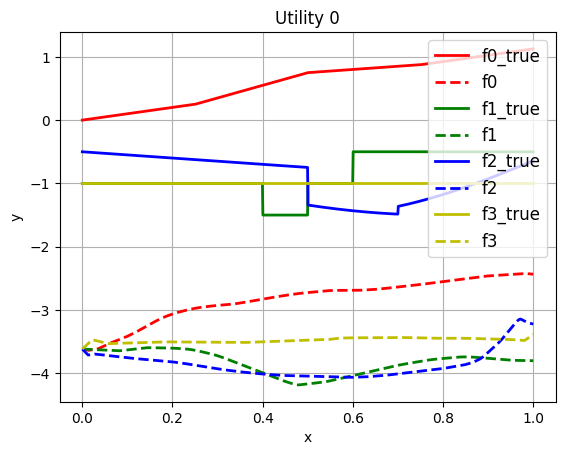

In [38]:
x_plot = np.linspace(1e-4, 1, 1000)

y_plot = []

for i in range(len(feature_names)):
    plot_dataset = pd.DataFrame({feature_names[i]: np.zeros_like(x_plot) for i in range(f_per_utility*n_utility)})
    plot_dataset[feature_names[i]] = x_plot
    plot_dataset_lgb = lightgbm.Dataset(plot_dataset, free_raw_data=False)

    if n_utility == 2:
        y_plot.append(LPMC_model_fully_trained.predict(plot_dataset_lgb, utilities=True))
    else:
        y_plot.append(LPMC_model_fully_trained.predict(plot_dataset_lgb, utilities=True)[:, i // f_per_utility])
    if LPMC_model_fully_trained.device is not None:
        y_plot[-1] = y_plot[-1].cpu().numpy()

colours = ["r", "g", "b", "y", "k", "magenta", "cyan", "orange", "purple", "brown", "pink", "grey", "olive", "lime", "teal", "coral"]


if n_utility == 2:
    
    y_plot_true = []
    for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
        if i % f_per_utility == 0:
            plt.figure()
        if i % f_per_utility == 0:
            y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [0]).values
        elif i % f_per_utility == 1:
            y_plot_true = apply_constant_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        elif i % f_per_utility == 2:
            y_plot_true = apply_sinusoidal_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        elif i % f_per_utility == 3:
            y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
    
    y_plot_ttrue = [y_1 - y_0 for y_0, y_1 in zip(y_plot_true[0], y_plot_true[1])]
    y_plot_ttrue = np.array(y_plot_ttrue).reshape(-1)

    plt.plot(x_plot, y_plot_ttrue, label=f"{feature_names[0]}_true", color=colours[0], linewidth=2)
        # ascc = ascs[i//f_per_utility].cpu().numpy() if LPMC_model_fully_trained.device is not None else ascs[i//f_per_utility]
        # plt.plot(x_plot, y_plot[i]+ascc, label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)
    plt.plot(x_plot, y_plot[0], label=feature_names[0], color=colours[0], linestyle="--", linewidth=2)

    plt.title(f"Utility 0")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.legend(fontsize=12)
    plt.show()
else:
    for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
        if i % f_per_utility == 0:
            plt.figure()
        if i % f_per_utility == 0:
            y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [0]).values
        elif i % f_per_utility == 1:
            y_plot_true = apply_constant_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        elif i % f_per_utility == 2:
            y_plot_true = apply_sinusoidal_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        elif i % f_per_utility == 3:
            y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        # y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        plt.plot(x_plot, y_plot_true, label=f"{feature_names[i]}_true", color=colours[i], linewidth=2)
        # ascc = ascs[i//f_per_utility].cpu().numpy() if LPMC_model_fully_trained.device is not None else ascs[i//f_per_utility]
        # plt.plot(x_plot, y_plot[i]+ascc, label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)
        plt.plot(x_plot, y_plot[i], label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)



        if i % f_per_utility == f_per_utility - 1:
            plt.title(f"Utility {i//f_per_utility}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.grid()
            plt.legend(fontsize=12)
            plt.show()

    # for i in range(len(feature_names)):
    #     plt.figure()
    #     plt.hist(dataset[feature_names[i]], bins=150, alpha=0.5, label=feature_names[i])

In [56]:

from interpret.glassbox import APLRClassifier, ExplainableBoostingClassifier, APLRRegressor, ExplainableBoostingRegressor
from lightgbm import train
# model_aplr = APLRRegressor(random_state=1, m=1000, max_interaction_level=0, verbosity=2, min_observations_in_split=1, v = 0.1, bins=2000, cv_folds=2)
model_aplr = ExplainableBoostingRegressor(random_state=42, max_leaves=2)
# model_aplr = ExplainableBoostingClassifier(random_state=42)
model_aplr.fit(dataset[features].values, dataset["choice"])

ExplainableBoostingRegressor()

In [57]:
from rumboost.metrics import cross_entropy
# preds = model_aplr.predict_class_probabilities(dataset_test[features[0]].values)
if n_utility > 1:
    preds = model_aplr.predict_proba(dataset_test[features].values)
    print(cross_entropy(preds, dataset_test["choice"].astype(int).values))
else:
    preds = model_aplr.predict(dataset_test[features].values)
    mse = np.mean((preds - dataset_test["choice"].values)**2)
    print(f"Mean squared error: {mse}")

Mean squared error: 8.132851361518844e-05


In [58]:

from interpret import show
show(model_aplr.explain_global())

<!-- http://127.0.0.1:7001/136054460064208/ -->

In [67]:
lgb_train_set.construct()

In [23]:
LPMC_model_fully_trained.boosters[0].get_split_value_histogram("f0")

(array([ 4,  3,  2,  2,  3,  9,  3,  1,  6,  9,  0,  5,  0,  4,  6,  0, 17,
         9,  3,  0,  3,  8,  0,  0,  2,  0,  0,  0,  1]),
 array([0.02168464, 0.04405916, 0.06643367, 0.08880818, 0.1111827 ,
        0.13355721, 0.15593172, 0.17830624, 0.20068075, 0.22305526,
        0.24542978, 0.26780429, 0.2901788 , 0.31255332, 0.33492783,
        0.35730234, 0.37967686, 0.40205137, 0.42442588, 0.44680039,
        0.46917491, 0.49154942, 0.51392393, 0.53629845, 0.55867296,
        0.58104747, 0.60342199, 0.6257965 , 0.64817101, 0.67054553]))

In [ ]:
import json

class LinearTree:
    def __init__(self, x, monotonic_constraint = 0, max_bins=255):
        """ x must be 1d shape"""
        self.bin_edges, self.histograms, self.bin_indices = self.build_lightgbm_style_histogram(x, max_bins)
        self.bin_indices = self.bin_indices.reshape(1, -1).repeat(self.bin_edges.shape[0], axis=0)
        self.x = x
        self.monotonic_constraint = monotonic_constraint
        self.upper_bound = 0
        self.lower_bound = 0
        self.x_minus_bin_edges = self.x[None, :] - self.bin_edges[1:-1, None] 
        self.split_and_leaf_values = {
                        "splits": np.array([x.min(), x.max()]),
                        "constants": np.array([0.0, 0.0]),
                        "leaves": np.array([0.0]),
                        "value_at_splits": np.array([0.0, 0.0]),
                    }
        self.feature_importance = {"gain": np.array([])}
        # x_0 - e_0, x_0 - e_1, ...
        # x_1 - e_0, x_1 - e_1, ...


    def build_lightgbm_style_histogram(feature_values, max_bins=255):

        percentiles = np.linspace(0, 100, max_bins + 1)
        bin_edges = np.unique(np.percentile(feature_values, percentiles))

        bin_indices = np.digitize(feature_values, bins=bin_edges[1:-1], right=True)

        histogram = np.bincount(bin_indices, minlength=len(bin_edges) - 1)

        return bin_edges, histogram, bin_indices

    def update(self, _, fobj):

        grad, hess = fobj(_, _)
        grad_x = grad * self.x_minus_bin_edges
        hess_x = hess * self.x_minus_bin_edges

        N = self.bin_indices.max()+1
        id = self.bin_indices + (N*np.arange(self.bin_indices.shape[0]))[:,None]

        grad_x_binned = np.bincount(id.ravel(), weights=grad_x.ravel()).reshape(-1, N)
        hess_x_binned = np.bincount(id.ravel(), weights=hess_x.ravel()).reshape(-1, N)

        arange = np.arange(grad_x_binned.shape[0])
        edgerange = np.arange(grad_x_binned.shape[0]-1) + 1
        mask = arange[None, :] < edgerange[:, None]

        left_gain = grad_x_binned[mask].sum(axis=0) ** 2 / hess_x_binned[mask].sum(axis=0)
        left_leaf = - grad_x_binned[mask].sum(axis=0) / hess_x_binned[mask].sum(axis=0)

        right_gain = grad_x_binned[~mask].sum(axis=0) ** 2 / hess_x_binned[~mask].sum(axis=0)
        right_leaf = - grad_x_binned[~mask].sum(axis=0) / hess_x_binned[~mask].sum(axis=0)

        no_split_gain = grad_x_binned.sum() / hess_x_binned.sum()

        if self.monotonic_constraint == 1:
            left_gain[left_leaf < self.lower_bound] = -np.inf
            right_gain[right_leaf < self.lower_bound] = -np.inf
        
        if self.monotonic_constraint == -1:
            left_gain[left_leaf > self.upper_bound] = -np.inf
            right_gain[right_leaf > self.upper_bound] = -np.inf

        gain = left_gain + right_gain - no_split_gain

        best_index = np.argmax(gain)
        best_threshold = self.bin_edges[best_index+1]
        best_left_leaf = left_leaf[best_index]
        best_right_leaf = right_leaf[best_index]
        best_gain = gain[best_index]
        self.feature_importance["gain"].append(best_gain)

        self._update_linear_constants(best_threshold, (best_left_leaf, best_right_leaf))

    def _update_linear_constants(self, split_values, leaf_values):
        """

        """
        s = split_values
        l_0 = leaf_values[0]
        l_1 = leaf_values[1]
        if (
            s in self.split_and_leaf_values["splits"]
        ):  # if the split value exists already
            index = np.searchsorted(self.split_and_leaf_values["splits"], s)
            self.split_and_leaf_values["leaves"][:index] += l_0

            self.split_and_leaf_values["leaves"][index:] += l_1

            self.split_and_leaf_values["constants"] = np.concatenate(
                (
                    self.split_and_leaf_values["constants"][: index + 1]
                    + l_1 * s, 
                    self.split_and_leaf_values["constants"][index + 1 :]
                    + l_0 * s,
                )
            )
        else:
            index = np.searchsorted(self.split_and_leaf_values["splits"], s)
            self.split_and_leaf_values["splits"] = np.insert(
                self.split_and_leaf_values["splits"], index, s
            )

            self.split_and_leaf_values["leaves"] = np.concatenate(
                (
                    self.split_and_leaf_values["leaves"][:index] + l_0,
                    self.split_and_leaf_values["leaves"][index - 1 :] + l_1,
                )
            )

            self.split_and_leaf_values["constants"] = np.concatenate(
                (
                    self.split_and_leaf_values["constants"][: index + 1]
                    + l_1 * s,
                    self.split_and_leaf_values["constants"][index:]
                    + l_0 * s,
                )
            )

        self.upper_bound = np.max(self.split_and_leaf_values["leaves"])
        self.lower_bound = np.min(self.split_and_leaf_values["leaves"])

        leaves = self.split_and_leaf_values["leaves"]
        splits = self.split_and_leaf_values["splits"]
        all_leaves = np.concatenate((leaves[0].reshape(-1), leaves))
        constants = self.split_and_leaf_values["constants"]

        self.split_and_leaf_values["value_at_splits"] = (
            all_leaves * splits + constants
        )
    
    def eval_train(self, feval):
        pass

    def eval_valid(self, feval):
        pass

    def model_to_string(self, _, __, ___) -> str:
        """
        Serialize the model to a JSON string.
        """
        model_dict = {
            "bin_edges": self.bin_edges.tolist(),
            "histograms": self.histograms.tolist(),
            "split_and_leaf_values": {
                k: v.tolist() for k, v in self.split_and_leaf_values.items()
            },
            "monotonic_constraint": self.monotonic_constraint,
            "upper_bound": self.upper_bound,
            "lower_bound": self.lower_bound,
            "feature_importance": self.feature_importance
        }
        return json.dumps(model_dict)

    def model_from_string(self, s: str):
        """
        Load the model from a JSON string.
        """
        model_dict = json.loads(s)
        self.bin_edges = np.array(model_dict["bin_edges"])
        self.histograms = np.array(model_dict["histograms"])
        self.split_and_leaf_values = {
            k: np.array(v) for k, v in model_dict["split_and_leaf_values"].items()
        }
        self.monotonic_constraint = model_dict["monotonic_constraint"]
        self.upper_bound = model_dict["upper_bound"]
        self.lower_bound = model_dict["lower_bound"]
        self.feature_importance = model_dict["feature_importance"]

    def free_dataset(self,):
        self.x = None

    def set_train_data_name(self, name: str) -> "LinearTree":
        """Set the name to the training Dataset.

        Parameters
        ----------
        name : str
            Name for the training Dataset.

        Returns
        -------
        self : Booster
            Booster with set training Dataset name.
        """
        self._train_data_name = name
        return self


In [55]:
a = np.array([0, 1, 2, 1]).reshape(1, -1)
a = a.repeat(3, axis=0)

In [56]:
grad_x = np.array([[1, 2, 3], [2, 1, 1], [0, 0, 0], [10, -1, 2]])

In [57]:
a

array([[0, 1, 2, 1],
       [0, 1, 2, 1],
       [0, 1, 2, 1]])

In [ ]:

id

array([[0, 1, 2, 1],
       [3, 4, 5, 4],
       [6, 7, 8, 7]])

In [59]:
a.max()

np.int64(2)

In [60]:
grad_x.ravel()

array([ 1,  2,  3,  2,  1,  1,  0,  0,  0, 10, -1,  2])

In [66]:
bb = np.bincount(id.ravel(), weights=grad_x.ravel()).reshape(-1, N)

In [95]:
arange = np.arange(bb.shape[0])

In [96]:
asquare = arange.reshape(1, -1).repeat(bb.shape[1], axis=0)

In [103]:
arange = np.arange(10)
edgerange = np.arange(9) + 1

In [109]:
(~(arange[None, :] < edgerange[:, None]))

array([[False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False,  True,  True,
         True],
       [False, False, False, False, False, False, False, False,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
         True]])